In [1]:
!pip uninstall scipy
!pip install scipy==1.1.0

Uninstalling scipy-1.1.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/scipy-1.1.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/scipy/*
Proceed (y/n)? y
  Successfully uninstalled scipy-1.1.0
  Using cached https://files.pythonhosted.org/packages/a8/0b/f163da98d3a01b3e0ef1cab8dd2123c34aee2bafbb1c5bffa354cc8a1730/scipy-1.1.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('FCN_pytorch')

Mounted at FCN_pytorch


In [3]:
%cd FCN_pytorch/'My Drive'/FCN_pytorch
!ls

/content/FCN_pytorch/My Drive/FCN_pytorch
091119_db2_epoch24	  result_short_epoch24_mask_.avi  sochi2.mp4
fcn.py			  road_dataset			  sochi.mp4
models			  road_dataset_061119		  train.ipynb
output_short.avi	  road_dataset_loader.py	  train.py
polytech_sol.avi	  road_dataset_utils.py		  utils.py
__pycache__		  run_model.ipynb
result_short_epoch24.avi  scores


In [0]:
%load fcn.py
%load road_dataset_loader.py
%load road_dataset_utils.py
%load utils.py


In [0]:
from fcn import VGGNet, FCN32s, FCN16s, FCN8s, FCNs
from road_dataset_loader import RoadDataset

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
import time
import sys
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
model_path = '091119_db2_epoch24'

ts = time.time()
fcn_model = torch.load(model_path)
fcn_model = fcn_model.cuda()
print("Finish cuda loading, time elapsed {}".format(time.time() - ts))


Finish cuda loading, time elapsed 2.4131133556365967


In [0]:
import cv2
import scipy

In [0]:
means = [118.6786, 118.1411, 116.2199]
n_class = 2

import sys
np.set_printoptions(threshold=sys.maxsize)

def predict_labels(img):

  # reduce mean
  img = img[:, :, ::-1]  # switch to BGR
  img = np.transpose(img, (2, 0, 1)) / 1.0
  img[0] -= means[0]
  img[1] -= means[1]
  img[2] -= means[2]
  img = img / 255.0

  # convert to tensor
  inp = torch.from_numpy(img.copy()).float()
  #print('inp.shape = {}'.format(inp.shape))

  inp = Variable(inp.cuda())
  #print('inp.shape = {}'.format(inp.shape))

  inp = inp[None, ...]
  #print('inp.shape = {}'.format(inp.shape))

  output = fcn_model(inp)
  output = output.data.cpu().numpy()
  N, _, h, w = output.shape
  pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)

  #print('pred.shape = {}'.format(pred.shape))
  #pred[0][x][y] = 0 or 1

  #plt.imshow(pred[0])
  #plt.show()

  return pred[0]

def show_result(image, label):

  #image = image[:, :, ::-1]  # switch to BGR
  #print('image.shape = {}'.format(image.shape))

  label = label * 255
  label = label.astype(np.uint8)
  label_3ch = np.zeros_like(image)
  label_3ch[:,:,1] = label
  
  overlay = cv2.addWeighted(image, 1.0, label_3ch, 0.5, 1.0)
  plt.imshow(overlay)
  plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


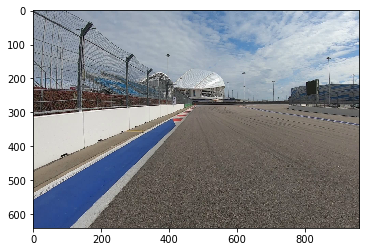

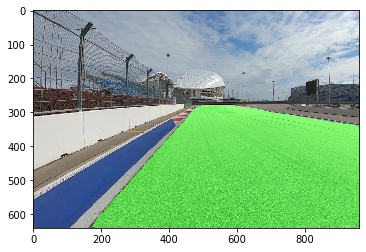

In [10]:
img = scipy.misc.imread('road_dataset/src/road_src_232.png', mode='RGB')
plt.imshow(img)
plt.show()

label = predict_labels(img)
show_result(img, label)

In [0]:
from google.colab.patches import cv2_imshow

def label_video(video_file_path, output_file_path, output_mask_file_path,
                start_frame=1, skip_frames=0):

  

  fourcc = cv2.VideoWriter_fourcc(*'XVID')
  out = cv2.VideoWriter(output_file_path, fourcc, 20.0, (960,640))
  if not out.isOpened():
    print('cannot open video file for writing')
    return

  fourcc2 = cv2.VideoWriter_fourcc(*'XVID')
  out_mask = cv2.VideoWriter(output_mask_file_path, fourcc2, 20.0, (960, 640))
  if not out_mask.isOpened():
    print('cannot open video file for writing')
    return

  cap = cv2.VideoCapture(video_file_path)
  curFrameNum = start_frame
  cap.set(1, curFrameNum)

  not_rets = 0
  while cap.isOpened():

    for _ in range(skip_frames+1):
      ret, image = cap.read()
      curFrameNum += 1

    if not ret:
      print('.',end='')
      not_rets += 1
      if not_rets > 30:
        break
      else:
        continue

    #print('frame = {}'.format(curFrameNum))

    image = cv2.resize(image, (960, 640))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ts = time.time()
    label = predict_labels(image_rgb)
    print("frame {}, time elapsed {}".format(curFrameNum, time.time() - ts))

    label = label * 255
    label = label.astype(np.uint8)
    label_3ch = np.zeros_like(image)
    label_3ch[:,:,1] = label

    overlay = cv2.addWeighted(image, 1.0, label_3ch, 0.5, 1.0)
    #cv2_imshow(overlay)
    #cv2.waitKey(1)
    out.write(overlay)
    out_mask.write(label_3ch)

  out.release()
  out_mask.release()
  cap.release()
  print('finished')



In [20]:
label_video('igora_draiv_yt.mp4', 'result_igora_draiv_yt_epoch24.avi', 'result_igora_draiv_yt_epoch24_mask_.avi', start_frame=1, skip_frames=0)

frame 2, time elapsed 0.4367799758911133
frame 3, time elapsed 0.366779088973999
frame 4, time elapsed 0.32857823371887207
frame 5, time elapsed 0.32961535453796387
frame 6, time elapsed 0.32495665550231934
frame 7, time elapsed 0.3272390365600586
frame 8, time elapsed 0.3378922939300537
frame 9, time elapsed 0.32551074028015137
frame 10, time elapsed 0.33304262161254883
frame 11, time elapsed 0.32895588874816895
frame 12, time elapsed 0.32870030403137207
frame 13, time elapsed 0.3287792205810547
frame 14, time elapsed 0.3253669738769531
frame 15, time elapsed 0.3248744010925293
frame 16, time elapsed 0.3250007629394531
frame 17, time elapsed 0.3277623653411865
frame 18, time elapsed 0.3322141170501709
frame 19, time elapsed 0.3240981101989746
frame 20, time elapsed 0.3335545063018799
frame 21, time elapsed 0.3355441093444824
frame 22, time elapsed 0.3236713409423828
frame 23, time elapsed 0.33429813385009766
frame 24, time elapsed 0.32619190216064453
frame 25, time elapsed 0.327711582

In [21]:
!ls

091119_db2_epoch24			 result_sochi2_epoch24_mask_.avi
create_trajectory.ipynb			 result_sochi_epoch24.avi
fcn.py					 result_sochi_epoch24_mask_.avi
igora_draiv_yt.mp4			 road_dataset
models					 road_dataset_061119
output_short.avi			 road_dataset_loader.py
polytech_sol.avi			 road_dataset_utils.py
__pycache__				 run_model.ipynb
result_igora_draiv_yt_epoch24.avi	 scores
result_igora_draiv_yt_epoch24_mask_.avi  sochi2.mp4
result_polytech_sol_epoch24.avi		 sochi.mp4
result_polytech_sol_epoch24_mask_.avi	 train.ipynb
result_short_epoch24.avi		 train.py
result_short_epoch24_mask_.avi		 utils.py
result_sochi2_epoch24.avi
